# TRAPPIST-1 Follow-up

In this tutorial, we will use the discovery data for the TRAPPIST-1 planetary system to illustrate how to use `transitforecast` to prioritize follow-up windows.

In [69]:
# Import some packages we know we're going to need
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [70]:
%matplotlib notebook

## Load the data

First, let's load in the dataset.

In [1]:
d = pd.read_csv('trappist1_lc_flat.csv')
d

,time,flux,flux_err,trend
0,2.457283e+06,0.996553,NaN,0.999392
1,2.457283e+06,0.997024,NaN,0.999422
2,2.457283e+06,0.995654,NaN,0.999356
3,2.457283e+06,1.000173,NaN,0.999391
4,2.457283e+06,1.001591,NaN,0.999457
...,...,...,...,...
12507,2.457390e+06,0.997818,NaN,1.000000
12508,2.457390e+06,0.994002,NaN,1.000000
12509,2.457390e+06,1.005075,NaN,1.000000
12510,2.457390e+06,0.994781,NaN,1.000000


No flux uncertainties are provided, so we'll use the median absolute deviation of the fluxes to estimate them.

In [2]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(d.flux, scale='normal')
d.flux_err = mad
d

,time,flux,flux_err,trend
0,2.457283e+06,0.996553,0.004316,0.999392
1,2.457283e+06,0.997024,0.004316,0.999422
2,2.457283e+06,0.995654,0.004316,0.999356
3,2.457283e+06,1.000173,0.004316,0.999391
4,2.457283e+06,1.001591,0.004316,0.999457
...,...,...,...,...
12507,2.457390e+06,0.997818,0.004316,1.000000
12508,2.457390e+06,0.994002,0.004316,1.000000
12509,2.457390e+06,1.005075,0.004316,1.000000
12510,2.457390e+06,0.994781,0.004316,1.000000


We could work with the data in a `pandas.DataFrame` at this point, but we'll use a `lightkurve.LightCurve` to hold the data instead so that we can take advantage of some additional functionality of that class.

In [3]:
lc = lk.LightCurve(
    time=d.time,
    flux=d.flux,
    flux_err=d.flux_err
)
lc

For example, let's take a look at the data.

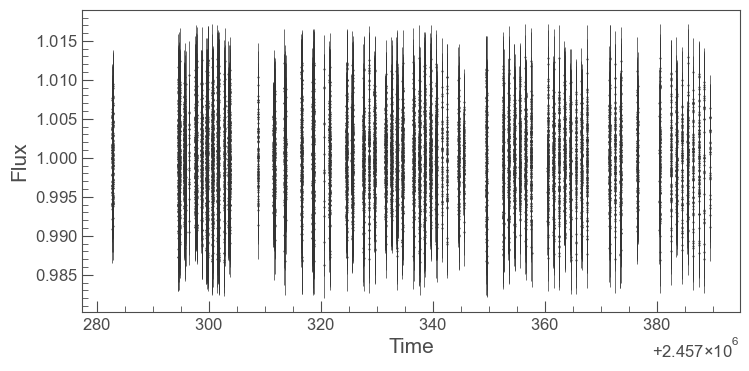

In [10]:
lc.errorbar(marker='.');

And let's phase-fold the light curve on the top `t0` and `period` returned by a `transitleastsquares` search.

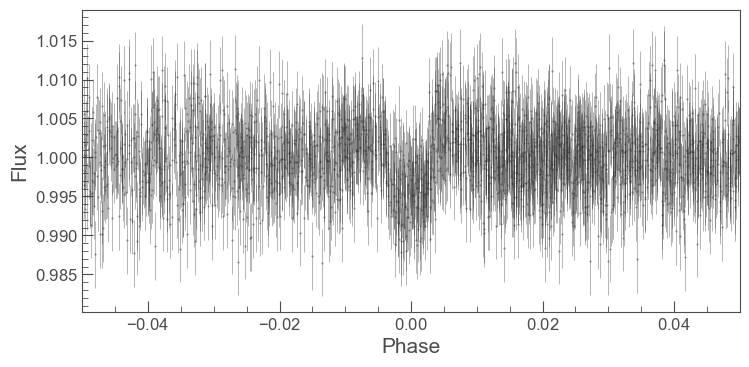

In [20]:
pri_t0 = 2457283.235
pri_p = 3.02164958340094
pri_rprs = 0.06027618

ax = lc.fold(t0=pri_t0, period=pri_p).errorbar(marker='.', alpha=0.5)
ax.set_xlim(-0.05, 0.05);

In fact, let's look at the top 5 scenarios returned by a `tls` search.

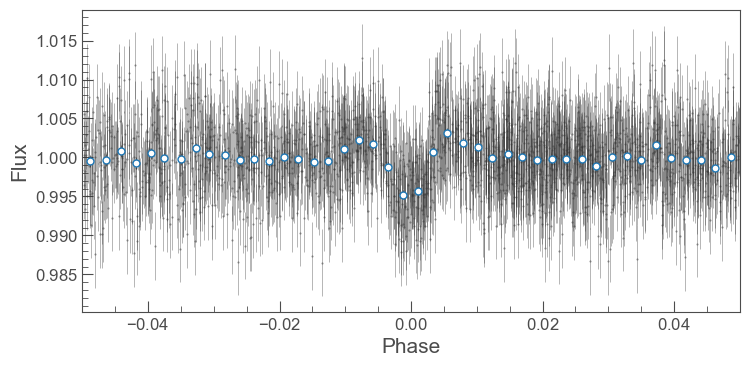

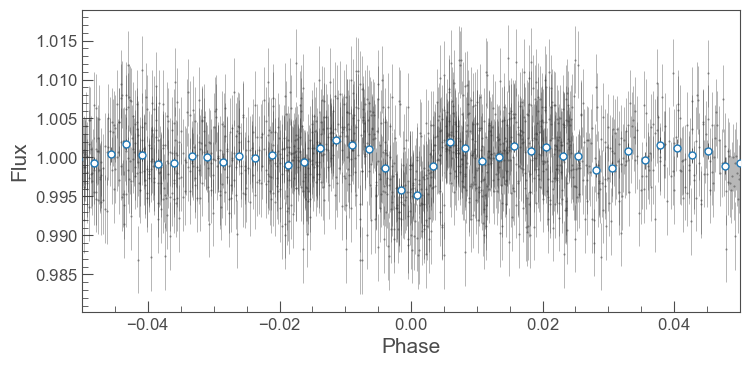

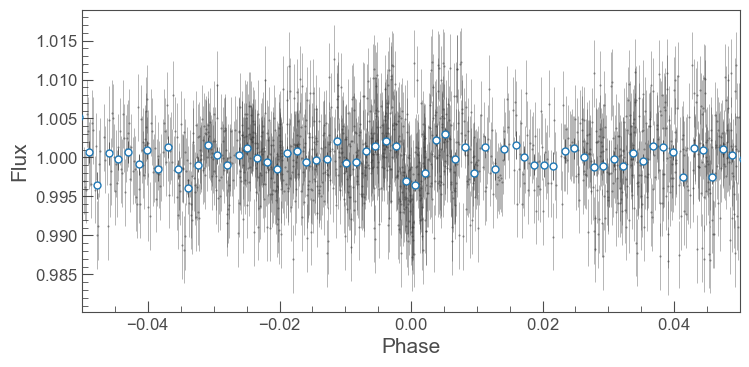

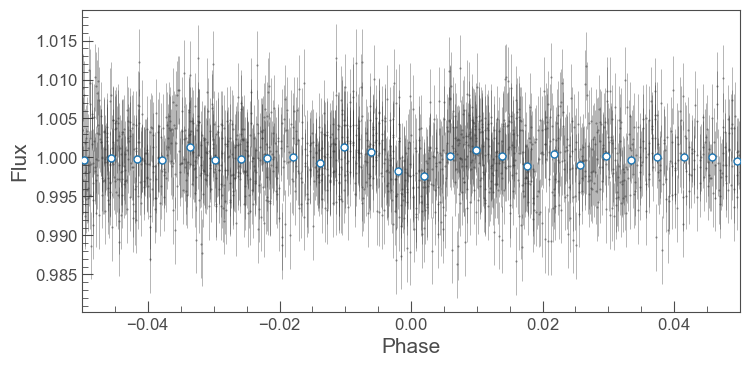

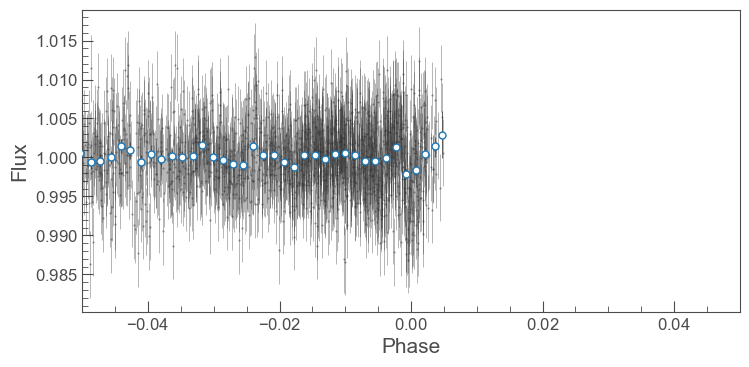

In [21]:
pri_t0s = [2457283.235, 2457282.803, 2457283.147, 2457283.696, 2457284.860] 
pri_ps = [3.02164958340094, 2.825653469, 4.615432934, 1.753996325, 4.487644045]
pri_rprss = [0.06027618, 0.059468536, 0.050877637, 0.042044128, 0.048652169]

for pri_t0, pri_p, pri_rprs in zip(pri_t0s, pri_ps, pri_rprss):
    ax = lc.fold(t0=pri_t0, period=pri_p).errorbar(marker='.', alpha=0.5)
    
    # Bin the light curve
    bins = int(pri_p/(10/(24*60)))  # 10-min bins
    binned_lc = lc.fold(t0=pri_t0, period=pri_p).bin(bins=bins)
    binned_lc.errorbar(ax=ax, marker='o', ms=5, color='C0', mfc='white', alpha=1, zorder=10)
    ax.set_xlim(-0.05, 0.05);

# MCMC Fit to Scenarios

Cool, now we'll use `transitforecast` to explore each of these scenarios with a MCMC. The goal is not to converge on a fit for each, but to explore the range of possible transit scenarios suggested by this dataset, using these TLS results as a jumping-off point.

We will generate a forecasted transit model for every accepted step in the MCMC, so we need to define our window of interest first.

In [30]:
import astropy.units as units

forecast_window = (0.5*units.yr).to(units.d).value
cadence = (2.*units.min).to(units.d).value

tforecast = lc.time.max() + np.arange(0, forecast_window, cadence)
tforecast

array([2457389.54448   , 2457389.54586889, 2457389.54725778, ...,
       2457572.16531333, 2457572.16670222, 2457572.16809111])

We also need priors for the stellar mass and radius. We can get these by querying the TESS Input Cataog via a convenience function provided by the `transitleastsquares` package.

In [31]:
import transitforecast as tf
import transitleastsquares as tls

tic_id = 278892590

# Wrapper for the tls.catalog_info() function
pri_m_star, pri_m_star_err, pri_r_star, pri_r_star_err = tf.get_priors_from_tic(tic_id)

Okay, now we have everything we need for the MCMC sampling.

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 49852.04266252143 -> 49852.04266252146
optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49852.04266252152 -> 49852.04266252152


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 113 seconds.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful re

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.80275309803


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49797.476565277684 -> 49810.4685757042


optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.4685757042 -> 49810.4685757042


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.4685757042 -> 49810.46857570421


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.46857570421 -> 49810.46857570422


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.46857570422 -> 49810.46857570422


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8571934045086229, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8850507445658534, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.65949582547


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.65949582547


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.659495825494


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.659495825494 -> 49804.659495825494


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 134 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8681001191267623, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8517855060931511, but should be close to 0.95. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8503846328636386, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Ke

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49772.318572987955 -> 49788.99616171782


optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171782 -> 49788.99616171782


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171782 -> 49788.99616171783


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171783 -> 49788.99616171783


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171783 -> 49788.99616171783


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 324 seconds.
The acceptance probability does not match the target. It is 0.8123307444231325, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4139118876723893, but should be close to 0.95. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6695813002250288, but should be close to 0.95. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5078415402842344,

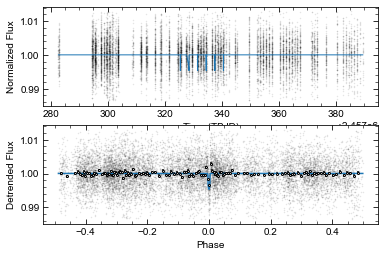

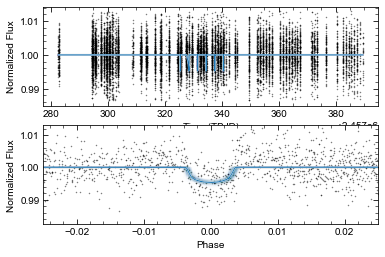

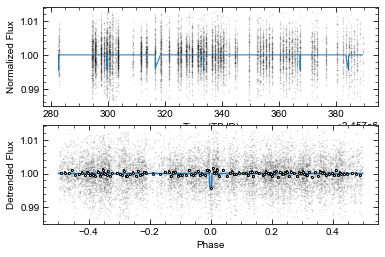

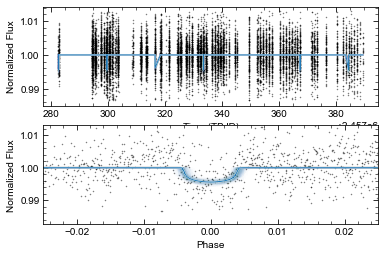

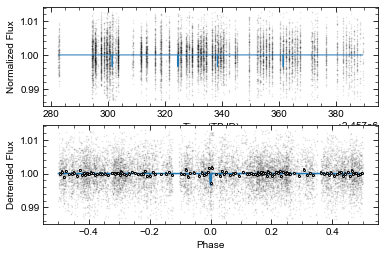

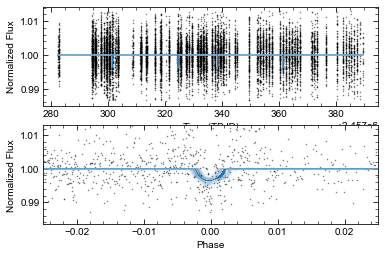

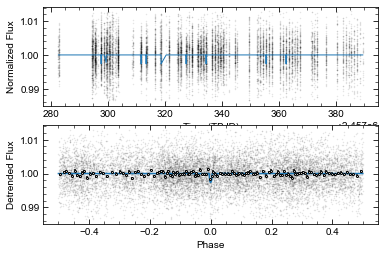

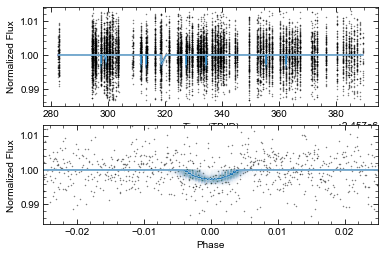

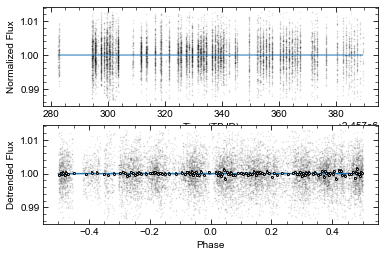

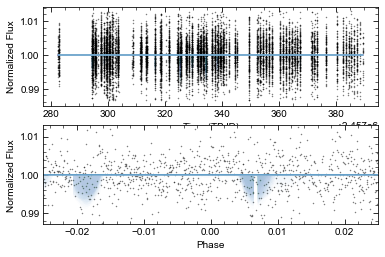

In [33]:
models = []
map_solns = []
traces = []
for i, (pri_t0, pri_p, pri_rprs) in enumerate(zip(pri_t0s, pri_ps, pri_rprss)):
    model, map_soln = tf.build_model(
        lc, pri_t0, pri_p, pri_rprs, pri_m_star, pri_m_star_err, pri_r_star, pri_r_star_err, tforecast
    )
    tf.plot_map_soln(lc, map_soln)
    trace = tf.sample_from_model(model, map_soln)
    fig, axes =  tf.plot_posterior_model(lc, trace)

    models.append(model)
    map_solns.append(map_soln)
    traces.append(trace)

Now we have a list, `traces`, which includes the results of the MCMC sampling of each of these scenarios.

In [35]:
traces

[<MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>]

Let's take a quick look at the posteriors for the most interesting parameters for follow up: `t0`, `period`, and `r`.

In [84]:
import pymc3 as pm

for i, trace in enumerate(traces):
    summary = pm.summary(
        trace,
        var_names=['t0', 'period', 'r'],
        round_to=8
    )
    print(f'Scenario {i}')
    print(summary)

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 0
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.005968  2.457283e+06  2.457283e+06   0.002099   
period  3.021900e+00  0.000361  3.021235e+00  3.022574e+00   0.000006   
r       6.644218e-02  0.004840  5.718573e-02  7.492399e-02   0.000097   

         mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail     r_hat  
t0      0.001628     8.084633     7.306942  3441.719226  3056.536510  1.000488  
period  0.000004  3357.483192  3357.483192  3377.193377  3053.812996  1.000663  
r       0.000070  2497.256829  2406.890660  2699.075418  2434.921141  1.001527  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 1
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.001154  2.457283e+06  2.457283e+06   0.000405   
period  2.825557e+00  0.000062  2.825443e+00  2.825679e+00   0.000001   
r       6.159650e-02  0.004877  5.203303e-02  7.014388e-02   0.000128   

             mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail  \
t0      2.972600e-04     8.125220     8.125220  2682.525634  2766.027250   
period  9.200000e-07  2289.607066  2289.607066  2285.017170  2453.415849   
r       9.020000e-05  1462.587581  1462.587581  1488.510981  1696.584926   

           r_hat  
t0      1.002389  
period  1.003053  
r       1.003883  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 2
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.003146  2.457283e+06  2.457283e+06   0.000117   
period  4.615489e+00  0.000273  4.614956e+00  4.615938e+00   0.000007   
r       1.928816e-01  0.247568  3.858013e-02  7.731303e-01   0.032793   

         mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail     r_hat  
t0      0.000813   727.662128     8.086186   331.975700  1694.226146  1.022843  
period  0.000005  1492.842880  1492.842880  1676.819682  1613.211533  1.004857  
r       0.023308    56.993767    56.993767    68.684078   298.038023  1.094919  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 3
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457284e+06  0.003791  2.457284e+06  2.457284e+06   0.001320   
period  1.753962e+00  0.000120  1.753755e+00  1.754177e+00   0.000004   
r       2.271406e-01  0.283232  3.163018e-02  8.692630e-01   0.015683   

         mcse_sd    ess_mean      ess_sd    ess_bulk     ess_tail     r_hat  
t0      0.000969    8.243697    8.243697  848.524435  1386.154407  1.012117  
period  0.000003  804.501261  804.494249  845.434956  1292.580362  1.014567  
r       0.011100  326.149854  326.149854  326.796613   382.957515  1.020721  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 4
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457285e+06  0.667531  2.457285e+06  2.457287e+06   0.190843   
period  4.464018e+00  0.066083  4.331532e+00  4.552260e+00   0.021079   
r       2.812385e-01  0.286799  3.962000e-05  8.715245e-01   0.070785   

         mcse_sd   ess_mean     ess_sd   ess_bulk   ess_tail     r_hat  
t0      0.138301  12.234661  12.234661  11.207089  35.633979  1.927857  
period  0.015371   9.828436   9.828436  10.544417  12.370380  2.105294  
r       0.050970  16.416213  16.416213  17.750392  45.269555  1.383636  


Judging by the $\hat{R}$ values, Scenarios 0 and 1 settled into relatively more stable solutions, while the rest were sampling from "all over the place."

# Identifying follow-up windows

## Calculating all events in the forecasted window

Let's identify the best follow-up windows for testing these scenarios. First, we'll identify all events present in our forecast window.

In [36]:
windows = tf.summarize_windows(traces, tforecast)
windows

scenario,median,lower,upper,tpm
int64,object,object,object,float64
0,2457392.018242335,2457392.001564626,2457392.0352939866,0.0016683285603622867
0,2457395.040152821,2457395.0228860984,2457395.0577198043,0.001621908288612891
0,2457398.0620643753,2457398.044264331,2457398.080142934,0.0015791753795331785
0,2457401.0839760997,2457401.0655964096,2457401.1025636224,0.0015186942616830842
0,2457404.105887393,2457404.086915589,2457404.1249821777,0.0014789952027615169
0,2457407.1277979384,2457407.1082836357,2457407.147444894,0.0014576903529674547
0,2457410.149709369,2457410.1295767,2457410.1699172603,0.00140349113517098
0,2457413.1716211205,2457413.1508883485,2457413.192382028,0.0013673863168567621
0,2457416.1935328525,2457416.172243345,2457416.2148402287,0.0013339861625549661


The `tf.summarize_windows()` function will identify peaks in $\bar{\mathcal{T}}$ and return a summary of them. The `windows` output is a `astropy.table.Table` listing for the median time of the peak, and lower and upper times defining the 95% confidence interval, and the `TPM` calculated by integrating the peak and normalizing by it's width. 

Let's visualize the windows.

<IPython.core.display.Javascript object>


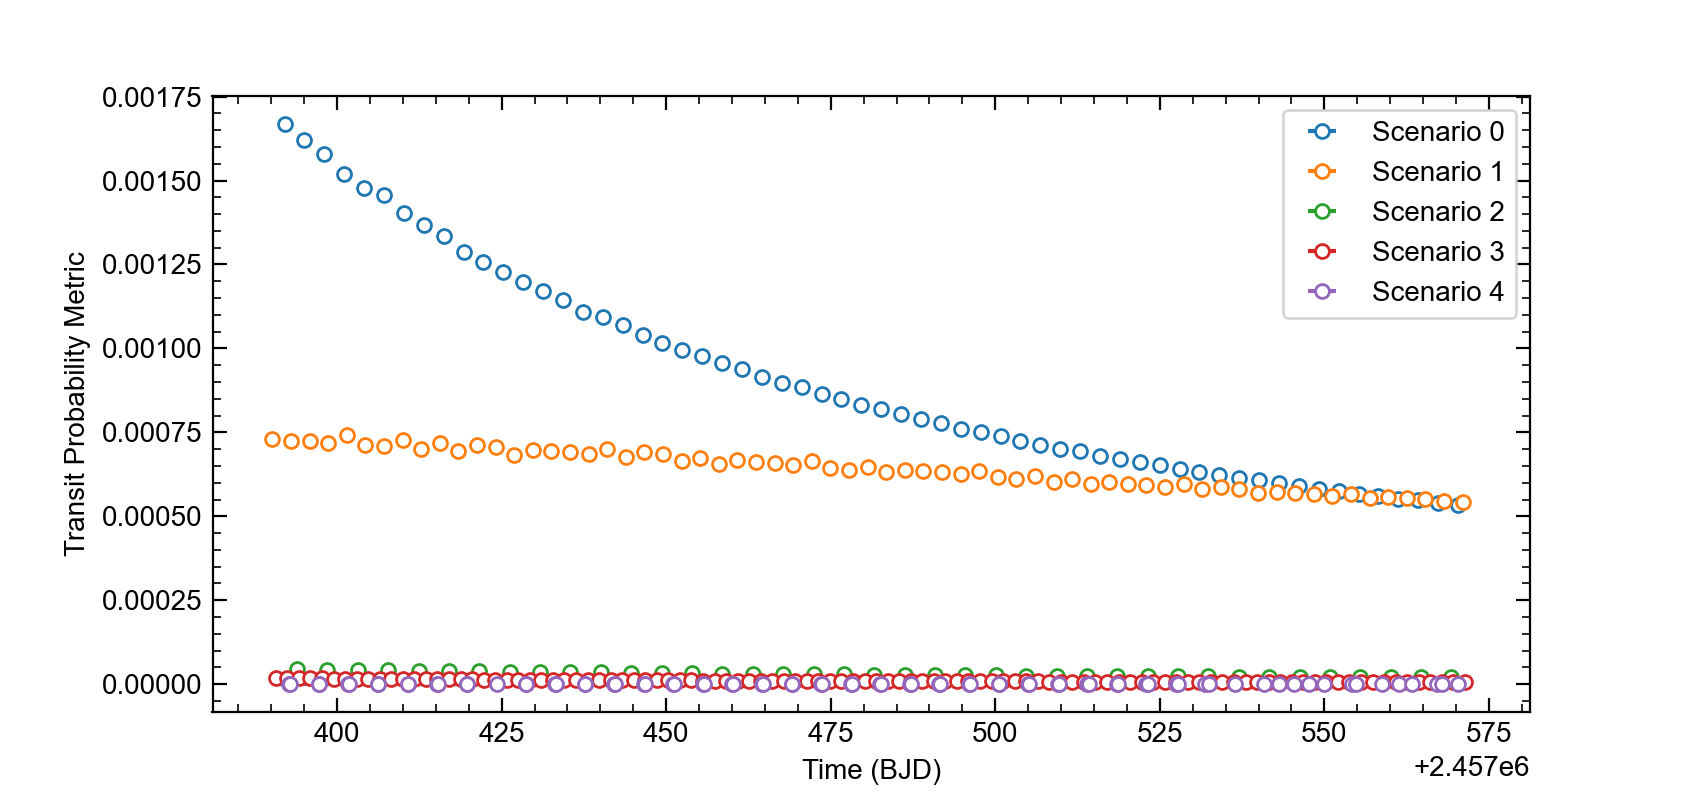

In [79]:
fig, ax = plt.subplots(figsize=(8.5, 4))

for i in np.unique(windows['scenario']):
    win = windows[windows['scenario'] == i]
    x = win['median'].jd
    y = win['tpm']
    xerr = [
        win['median'].jd-win['lower'].jd, 
        win['upper'].jd-win['median'].jd
    ]
    ax.errorbar(
        x, y, xerr=xerr, 
        ls='', marker='o', mfc='white', ms=5, label=f'Scenario {i}'
    )
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Transit Probability Metric');
ax.legend()

Scenarios 0 and 1 are definitely the most interesting to follow up, which makes sense because they were the first two signals identified by the TLS algorithm. The TPM for Scenario 0 degrades more quickly because it has a wide period posterior, causing the peaks in the transit prediction vector $\hat{\mathcal{T}}$ to get smeared out for most distant predictions.

## Identifying observable windows

Now let's see which of these will be observable from a given site (or list of sites, actually) using the `astroplan` package. To do so, we'll define our observing constraints, the sites, and the position of our object in the sky.

In [39]:
import astroplan as ap
from astropy.coordinates import SkyCoord
from astropy.time import Time

# Constraints
constraints = [
    ap.AtNightConstraint.twilight_civil(),
    ap.AltitudeConstraint(min=30.*units.deg),
    ap.MoonSeparationConstraint(min=30.*units.deg)
]

# Sites
sno = ap.Observer(
    longitude=-16.5097*units.deg, latitude=28.3*units.deg,
    elevation=2390*units.m, name='SNO', timezone='Atlantic/Canary'
)
sso = ap.Observer.at_site('Paranal')
saintex = ap.Observer.at_site(
    'Observatorio Astronomico Nacional, San Pedro Martir'
)
sites = [sno, sso, saintex]

# Target
target = ap.FixedTarget.from_name('TRAPPIST-1')

Now we'll identify the observable events for each site with `tf.observable_windows()`. This returns an `astropy.table.Table` with the scenario, tpm, and times and airmasses for the median transit prediction and the start and end of the observation, taking into account the 95% confidence interval for the prediction and the observing constraints.

In [89]:
obs_per_site = []
for site in sites:
    obs = tf.observable_windows(target, site, constraints, windows)
    obs_per_site.append(obs)
obs

scenario,tpm,fraction,start,median,end,zstart,zmedian,zend
,,,,,,,,
int64,float64,float64,object,object,object,float64,float64,float64
0,0.0006518457156379603,0.23809523809523808,2457524.992570931,2457524.9823240247,2457525.012709819,1.9999545488895305,2.207430457868751,1.7276055434291244
0,0.0006423388422970922,0.3125,2457527.984635178,2457528.0042333184,2457528.0117185097,1.9957441459381815,1.7395219137492846,1.653866554646133
0,0.0006332173625815823,0.3384615384615385,2457530.980183958,2457531.026142216,2457531.0100450674,1.936545640340364,1.4825421568636978,1.5952612859762891
0,0.0006219421126592811,0.09090909090909091,2457534.0014389204,2457534.0480509805,2457534.009077809,1.5987868521927875,1.3362133574501962,1.5381001023696734
1,0.0005421460365581954,0.5111111111111111,2457570.9942936883,2457571.01018368,2457571.009571465,1.2396372863633798,1.2359726161749898,1.2359997527372089
3,7.378132702181157e-06,0.4,2457523.9959842316,2457523.990427763,2457524.0133453417,1.988719459831464,2.09990154918907,1.7510568005365321
3,7.1269269547768915e-06,0.5373134328358209,2457530.9861723585,2457531.006269774,2457531.0104779126,1.8509581047156343,1.6355476459539824,1.5916162567543786
4,1.0221457961976556e-06,0.07877316857899382,2457390.5543899643,2457392.7332725264,2457392.6342509515,1.314421455826595,49.205403835094216,1.9915073483141492


Let's visualize the results.

<IPython.core.display.Javascript object>


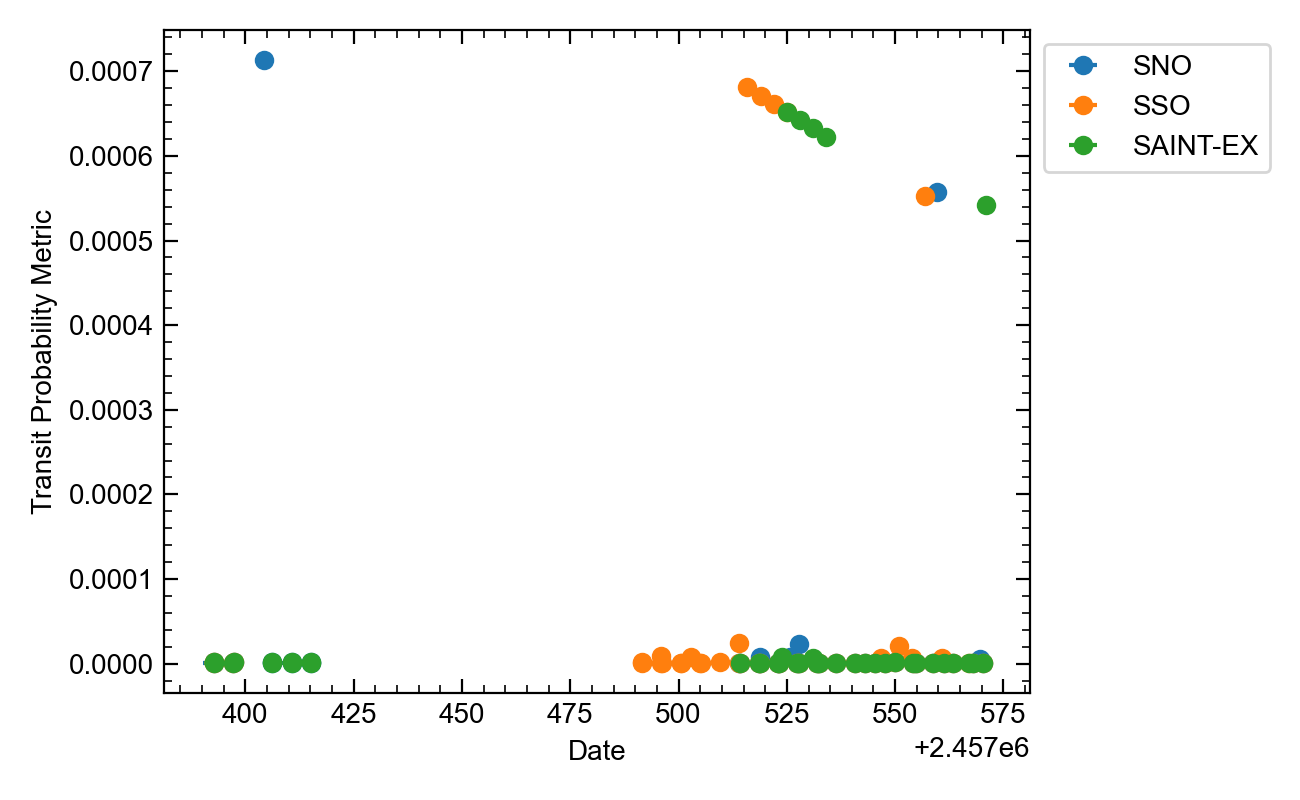

In [94]:
fig, ax = plt.subplots(figsize=(6.5, 4))

site_names = ['SNO', 'SSO', 'SAINT-EX']
for i, obs in enumerate(obs_per_site):
    pdobs = obs.to_pandas()
    ax.errorbar(
        obs['median'].jd, obs['tpm'], xerr=[obs['median'].jd-obs['start'].jd, obs['end'].jd-obs['median'].jd],
        ls='', marker='o', label=site_names[i], 
    )
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Transit Probability Metric')
plt.tight_layout()

Looks like there were a few high-TPM events (corresponding to Scenarios 0 and 1) and lots of low-TPM events that these faciltiies could have follow up in the first 6 months after the detection of TRAPPIST-1. The only problem is that none of them existed yet!